---

_You are currently looking at **version 1.5** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

# Assignment 3 - More Pandas
This assignment requires more individual learning then the last one did - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

In [2]:
import pandas as pd

import re

import numpy as np

import sys

In [3]:
# 1. Load energy data, excluding the header and footer info
energy = pd.read_excel("./Energy Indicators.xls", usecols= range(2, 6), skiprows=17, skipfooter=38)

# 2. Load the GDP data, exclude the header
GDP = pd.read_csv("./world_bank.csv",skiprows=4)

# 3. Load SciamEn data
ScimEn = pd.read_excel("./scimagojr-3.xlsx")

### Question 1 (20%)

Load the energy data from the file `Energy Indicators.xls`, which is a list of indicators of [energy supply and renewable electricity production](Energy%20Indicators.xls) from the [United Nations](http://unstats.un.org/unsd/environment/excel_file_tables/2013/Energy%20Indicators.xls) for the year 2013, and should be put into a DataFrame with the variable name of **energy**.

Keep in mind that this is an Excel file, and not a comma separated values file. Also, make sure to exclude the footer and header information from the datafile. The first two columns are unneccessary, so you should get rid of them, and you should change the column labels so that the columns are:

`['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']`

Convert `Energy Supply` to gigajoules (there are 1,000,000 gigajoules in a petajoule). For all countries which have missing data (e.g. data with "...") make sure this is reflected as `np.NaN` values.

Rename the following list of countries (for use in later questions):

```"Republic of Korea": "South Korea",
"United States of America": "United States",
"United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
"China, Hong Kong Special Administrative Region": "Hong Kong"```

There are also several countries with numbers and/or parenthesis in their name. Be sure to remove these, 

e.g. 

`'Bolivia (Plurinational State of)'` should be `'Bolivia'`, 

`'Switzerland17'` should be `'Switzerland'`.

<br>

Next, load the GDP data from the file `world_bank.csv`, which is a csv containing countries' GDP from 1960 to 2015 from [World Bank](http://data.worldbank.org/indicator/NY.GDP.MKTP.CD). Call this DataFrame **GDP**. 

Make sure to skip the header, and rename the following list of countries:

```"Korea, Rep.": "South Korea", 
"Iran, Islamic Rep.": "Iran",
"Hong Kong SAR, China": "Hong Kong"```

<br>

Finally, load the [Sciamgo Journal and Country Rank data for Energy Engineering and Power Technology](http://www.scimagojr.com/countryrank.php?category=2102) from the file `scimagojr-3.xlsx`, which ranks countries based on their journal contributions in the aforementioned area. Call this DataFrame **ScimEn**.

Join the three datasets: GDP, Energy, and ScimEn into a new dataset (using the intersection of country names). Use only the last 10 years (2006-2015) of GDP data and only the top 15 countries by Scimagojr 'Rank' (Rank 1 through 15). 

The index of this DataFrame should be the name of the country, and the columns should be ['Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations',
       'Citations per document', 'H index', 'Energy Supply',
       'Energy Supply per Capita', '% Renewable', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015'].

*This function should return a DataFrame with 20 columns and 15 entries.*

In [4]:
def combine(df1, df2, df3):
    # Create a shallow copy of the df "energy" for its reuse 
    energy = df1.copy()
    
    # Rename the columns for the DataFrame "energy", in prep for the later join
    energy.columns = ['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']
    
    ## Convert "Energy Supply" to gigajoules
    energy_supply_in_pj = energy.get("Energy Supply")
    energy_supply_in_gj = energy_supply_in_pj * 1000000
    energy["Energy Supply"] = energy_supply_in_gj

    ## Fill missing data with np.NaN() values
    energy.fillna(method='ffill')

    ## Rename countries
    places_to_rename = ({"United States of America": "United States", 
                         "United Kingdom of Great Britain and Northern Ireland": "United Kingdom", 
                         "China, Hong Kong Special Administrative Region": "Hong Kong", 
                         "Bolivia.*": "Bolivia", 
                         "Switzerland.*": "Switzerland",
                         "^China.?$":"China",
                         "^Japan.*":"Japan", 
                         "^France.?$":"France",
                         "^Republic of Korea.*$":"South Korea",
                         "^Italy.?$":"Italy",
                         "Spain.*":"Spain",
                         "Iran.*":"Iran",
                         "^Australia.?$":"Australia"})
    # Try to remove the trailing digits in any country names
    ## Remove countries with numbers/parenthesis in their name
    for index in range(energy['Country'].count()):    
        country = energy.at[index, 'Country'] # country is a copy of the value in the DataFrame at location [index,'Country']
        for place in places_to_rename.keys():
            pattern = re.compile(place)
            if(pattern.search(country)):
                energy.at[index, 'Country'] = places_to_rename[place] 

    # Create a shallow copy of df "GDP" for its reuse
    
    GDP = df2.copy()
    # Need to rename the column first before merging because Pandas handles identical merge column names differently than differing merge column names (See https://www.coursera.org/learn/python-data-analysis/discussions/weeks/3/threads/aurVNynyEemJtBIIwV3cWg)
    GDP.columns = ['Country' if c == 'Country Name' else c for c in df2.columns]
    ## Rename countries
    places_to_rename = {"Korea, Rep.": "South Korea", 
"Iran, Islamic Rep.": "Iran",
"Hong Kong SAR, China": "Hong Kong"}
    for index in (range(GDP['Country'].count())):
        country = GDP.at[index, 'Country']
        for place in places_to_rename.keys():
            pattern = re.compile(place)
            if(pattern.search(country)):
                GDP.at[index, 'Country'] = places_to_rename[place]

    # Create a shallow copy of df "ScimEn" for its reuse
    ScimEn = df3.copy()
    ScimEn = ScimEn.reset_index(drop=True)

    # 4. Join all three datasets, with only the last ten years of GDP data and only the top 15 countries by sciamgojr 'Rank'
    
    GDPInLastTenYearsIndices = [str(yr) for yr in range(2006, 2015+1)]
    GDPInLastTenYearsIndices.append('Country')
    energy_and_GDP = pd.merge(energy, GDP[GDPInLastTenYearsIndices], how='inner', on='Country')
    energy_and_GDP = energy_and_GDP.reset_index(drop=True)
    conglomerated = pd.merge(ScimEn, energy_and_GDP, how='left', left_on='Country', right_on='Country')
    conglomerated = (conglomerated.reset_index(drop=True)
                                    .set_index('Country'))
    return conglomerated

def answer_one():
    combined = combine(energy, GDP, ScimEn)
    answer = combined.where(combined['Rank'] < 16).head(15)
    # answer = combined.where(combined['Rank'] <= 15).dropna()
    return answer

answer_one()

,Rank,Documents,Citable documents,Citations,Self-citations,Citations per document,H index,Energy Supply,Energy Supply per Capita,% Renewable,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,
China,1.0,127050.0,126767.0,597237.0,411683.0,4.70,138.0,127191000000,93,19.754910,3.992331e+12,4.559041e+12,4.997775e+12,5.459247e+12,6.039659e+12,6.612490e+12,7.124978e+12,7.672448e+12,8.230121e+12,8.797999e+12
United States,2.0,96661.0,94747.0,792274.0,265436.0,8.20,230.0,90838000000,286,11.570980,1.479230e+13,1.505540e+13,1.501149e+13,1.459484e+13,1.496437e+13,1.520402e+13,1.554216e+13,1.577367e+13,1.615662e+13,1.654857e+13
Japan,3.0,30504.0,30287.0,223024.0,61554.0,7.31,134.0,18984000000,149,10.232820,5.496542e+12,5.617036e+12,5.558527e+12,5.251308e+12,5.498718e+12,5.473738e+12,5.569102e+12,5.644659e+12,5.642884e+12,5.669563e+12
United Kingdom,4.0,20944.0,20357.0,206091.0,37874.0,9.84,139.0,7920000000,124,10.600470,2.419631e+12,2.482203e+12,2.470614e+12,2.367048e+12,2.403504e+12,2.450911e+12,2.479809e+12,2.533370e+12,2.605643e+12,2.666333e+12
Russian Federation,5.0,18534.0,18301.0,34266.0,12422.0,1.85,57.0,30709000000,214,17.288680,1.385793e+12,1.504071e+12,1.583004e+12,1.459199e+12,1.524917e+12,1.589943e+12,1.645876e+12,1.666934e+12,1.678709e+12,1.616149e+12
Canada,6.0,17899.0,17620.0,215003.0,40930.0,12.01,149.0,10431000000,296,61.945430,1.564469e+12,1.596740e+12,1.612713e+12,1.565145e+12,1.613406e+12,1.664087e+12,1.693133e+12,1.730688e+12,1.773486e+12,1.792609e+12
Germany,7.0,17027.0,16831.0,140566.0,27426.0,8.26,126.0,13261000000,165,17.901530,3.332891e+12,3.441561e+12,3.478809e+12,3.283340e+12,3.417298e+12,3.542371e+12,3.556724e+12,3.567317e+12,3.624386e+12,3.685556e+12
India,8.0,15005.0,14841.0,128763.0,37209.0,8.58,115.0,33195000000,26,14.969080,1.265894e+12,1.374865e+12,1.428361e+12,1.549483e+12,1.708459e+12,1.821872e+12,1.924235e+12,2.051982e+12,2.200617e+12,2.367206e+12
France,9.0,13153.0,12973.0,130632.0,28601.0,9.93,114.0,10597000000,166,17.020280,2.607840e+12,2.669424e+12,2.674637e+12,2.595967e+12,2.646995e+12,2.702032e+12,2.706968e+12,2.722567e+12,2.729632e+12,2.761185e+12


### Question 2 (6.6%)
The previous question joined three datasets then reduced this to just the top 15 entries. When you joined the datasets, but before you reduced this to the top 15 items, how many entries did you lose?

*This function should return a single number.*

In [5]:
%%HTML
<svg width="800" height="300">
  <circle cx="150" cy="180" r="80" fill-opacity="0.2" stroke="black" stroke-width="2" fill="blue" />
  <circle cx="200" cy="100" r="80" fill-opacity="0.2" stroke="black" stroke-width="2" fill="red" />
  <circle cx="100" cy="100" r="80" fill-opacity="0.2" stroke="black" stroke-width="2" fill="green" />
  <line x1="150" y1="125" x2="300" y2="150" stroke="black" stroke-width="2" fill="black" stroke-dasharray="5,3"/>
  <text  x="300" y="165" font-family="Verdana" font-size="35">Everything but this!</text>
</svg>

In [74]:
# ans = entries in GDP + entries in energy + entries in ScimEn - (entries in both energy and GDP + entries in both GDP and ScimEn + entries in both energy and ScimEn) - 3 * entries in three dfs combined - entries in three dfs combined

# ans = # entries (energy outer join GDP) outer join ScimEn - # entries (energies inner join GDP) inner join ((energy outer join GDP) inner join ScimEn)
def answer_two():
    energy.columns = ['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']
    tdf_out = pd.merge(energy, GDP, how='outer', left_on='Country',right_on='Country Name')
    tdf_out = pd.merge(tdf_out, ScimEn, how='outer', left_on='Country',right_on='Country')
    
    ans = len(tdf_out)
    # print(ans)
    # print("Total entries before joining: {}".format(ans))
    # energy_and_GDP_2 = pd.merge(energy, GDP, how='left', left_on='Country',right_on='Country Name')
    # print(energy_and_GDP_2.index.size)
    # energy_and_GDP_2 = pd.merge(energy, GDP, how='right', left_on='Country',right_on='Country Name')
    # print(energy_and_GDP_2.index.size)
    tdf_in = pd.merge(energy, GDP, how='inner', left_on='Country',right_on='Country Name')
    tdf_in = pd.merge(tdf_in, ScimEn, how='inner', left_on='Country', right_on='Country')
    # print(common.index.size)
    ans = ans - len(tdf_in)

    # print("Total entries after joining: {}".format(ans))

    result = ans
    return result
# answer_two()

226

## Answer the following questions in the context of only the top 15 countries by Scimagojr Rank (aka the DataFrame returned by `answer_one()`)

### Question 3 (6.6%)
What is the average GDP over the last 10 years for each country? (exclude missing values from this calculation.)

*This function should return a Series named `avgGDP` with 15 countries and their average GDP sorted in descending order.*

In [39]:
def answer_three():
    Top15 = answer_one()  
    # Top15.dropna(subset=[str(yr) for yr in range(2006,2015+1)]) 
    df_data = {}
    # for index in range(Top15['Country'].count()): # The index column can not be used for indexing the data frame
    for index in range(Top15.index.size):
        country = Top15.index.values[index]
        totalGDP = Top15.iloc[index].loc[[str(yr) for yr in range(2006,2015+1)]]  
        avgGDPVal = totalGDP.mean(skipna=True)
        df_data[country] = avgGDPVal
    avgGDP = pd.Series(data=df_data, index=df_data.keys(), dtype=float)
    avgGDP.sort_values(ascending=False, inplace=True)        
    return avgGDP

### Question 4 (6.6%)
By how much had the GDP changed over the 10 year span for the country with the 6th largest average GDP?

*This function should return a single number.*

In [56]:
def answer_four():
    Top15 = answer_one()
    avgGDP = answer_three()
    # Find the country with the 6th largest avg GDP first, then calculate the change
    country = avgGDP.index[5]

    countryGDP = Top15.loc[country, [str(i) for i in range(2006, 2015+1)]]

    # changes = countryGDP.pct_change(periods=9)

    # ans2 = countryGDP['2006'] * changes['2015']

    # print(float(ans2))

    # ans = changes[changes.tail(1).index.values[0]]

    ans = countryGDP['2015'] - countryGDP['2006']

    return ans

### Question 5 (6.6%)
What is the mean `Energy Supply per Capita`?

*This function should return a single number.*

In [89]:
def answer_five():
    Top15 = answer_one()
    # ans = float(Top15['Energy Supply per Capita'].mean())
    ans = np.sum(Top15['Energy Supply per Capita']) / len(Top15)
    return ans

answer_five()

157.6

### Question 6 (6.6%)
What country has the maximum % Renewable and what is the percentage?

*This function should return a tuple with the name of the country and the percentage.*

In [90]:
def answer_six():
    Top15 = answer_one()
    maxPct = Top15['% Renewable'].max()
    country = (Top15.where(Top15['% Renewable'] == maxPct)
                    .dropna()
                    .reset_index()['Country']
                    .values[0])
    return (country, maxPct)

### Question 7 (6.6%)
Create a new column that is the ratio of Self-Citations to Total Citations. 
What is the maximum value for this new column, and what country has the highest ratio?

*This function should return a tuple with the name of the country and the ratio.*

In [76]:
def answer_seven():
    Top15 = answer_one()
    Top15['Self-Citations:Total Citations'] = Top15['Self-citations'] / Top15['Citations']
    max_ratio = Top15['Self-Citations:Total Citations'].max()
    country = (Top15.where(Top15['Self-Citations:Total Citations'] == max_ratio)
                    .dropna()
                    .reset_index()['Country']
                    .values[0]
                    )
    return (country, max_ratio)

('China', 0.6893126179389422)

### Question 8 (6.6%)

Create a column that estimates the population using Energy Supply and Energy Supply per capita. 
What is the third most populous country according to this estimate?

*This function should return a single string value.*

In [5]:
def addPopulationData(energyDf):
    population_data = energyDf['Energy Supply'] / energyDf['Energy Supply per Capita']
    population = pd.Series(data=population_data, dtype=float)
    energyDf.insert(len(energyDf.columns), column='Population', value=population.values)
    return energyDf

def answer_eight():
    Top15 = addPopulationData(answer_one())
    # Solution with sorting
    # print(Top15.head().loc[:, ['Energy Supply', 'Energy Supply per Capita', 'Population']])
    # Top15 = Top15.sort_values(by=['Population'], ascending=False)
    # answer = Top15.iloc[2].name # This is a series
    # Solution without sorting
    Top7 = Top15[Top15['Population'] > Top15['Population'].median()]
    Top3 = Top7[Top7['Population'] > Top7['Population'].median()]
    answer = Top3[Top3['Population'] <= Top3['Population'].min()].iloc[0].name 
    return answer

### Question 9 (6.6%)
Create a column that estimates the number of citable documents per person. 
What is the correlation between the number of citable documents per capita and the energy supply per capita? Use the `.corr()` method, (Pearson's correlation).

*This function should return a single number.*

*(Optional: Use the built-in function `plot9()` to visualize the relationship between Energy Supply per Capita vs. Citable docs per Capita)*

In [78]:
def answer_nine():
    Top15 = addPopulationData(answer_one())
    Top15['Citable documents per capita'] = Top15['Citable documents'] / Top15['Population']

    energy_supp_pc = Top15.loc[:, 'Energy Supply per Capita']
    citable_docs_pc = Top15.loc[:, 'Citable documents per capita']
    # Need to convert the data type to float in the series first before calculating the covariance
    energy_supp_pc = pd.Series(data=energy_supp_pc, dtype=float)
    citable_docs_pc = pd.Series(data=citable_docs_pc, dtype=float)
    answer = energy_supp_pc.corr(citable_docs_pc, method='pearson')

    return answer

0.7940010435442947

In [79]:
def plot9():
    import matplotlib as plt
    %matplotlib inline
    
    Top15 = answer_one()
    Top15['PopEst'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']
    Top15['Citable docs per Capita'] = Top15['Citable documents'] / Top15['PopEst']
    Top15 = pd.DataFrame(data=Top15.loc[:, ['Citable docs per Capita', 'Energy Supply per Capita']], dtype=float)
    Top15.plot(x='Citable docs per Capita', y='Energy Supply per Capita', kind='scatter', xlim=[0, 0.0006])

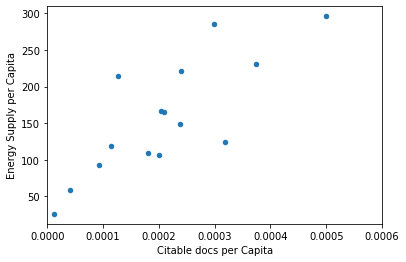

In [80]:
# plot9() # Be sure to comment out plot9() before submitting the assignment!

### Question 10 (6.6%)
Create a new column with a 1 if the country's % Renewable value is at or above the median for all countries in the top 15, and a 0 if the country's % Renewable value is below the median.

*This function should return a series named `HighRenew` whose index is the country name sorted in ascending order of rank.*

In [81]:
def answer_ten():
    Top15 = answer_one()
    Top15.sort_values(by='Rank')
    renewMedian = Top15['% Renewable'].median()
    HighRenewData = []
    for val in Top15.index.values:
        country = str(val)
        if(Top15.at[country, '% Renewable'] >= renewMedian):
            HighRenewData.append(1)
        else:
            HighRenewData.append(0)
    HighRenew = pd.Series(data=HighRenewData, index=Top15.index, dtype=int)
    return HighRenew

Country
China                 1
United States         0
Japan                 0
United Kingdom        0
Russian Federation    1
Canada                1
Germany               1
India                 0
France                1
South Korea           0
Italy                 1
Spain                 1
Iran                  0
Australia             0
Brazil                1
dtype: int64

### Question 11 (6.6%)
Use the following dictionary to group the Countries by Continent, then create a dateframe that displays the sample size (the number of countries in each continent bin), and the sum, mean, and std deviation for the estimated population of each country.

```python
ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
```

*This function should return a DataFrame with index named Continent `['Asia', 'Australia', 'Europe', 'North America', 'South America']` and columns `['size', 'sum', 'mean', 'std']`*

In [6]:
def categorize(mapping):
    for item in mapping.keys():
        return mapping[item]
    
def insertContinent(df):
    ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
    Continents = []
    for row in df.itertuples():
        index = row[0]
        Continents.append(ContinentDict[index])
    col_continents = pd.Series(data=Continents, dtype=str)

    # Insert the column 'Continent' into the data frame, at the end of columns
    df.insert(len(df.columns), column='Continent', value=col_continents.values) 
    return df  

def answer_eleven():
    try:
        Top15 = addPopulationData(answer_one())
        Top15 = insertContinent(Top15)
        ans = (Top15.reset_index()[['Country', 'Continent', 'Population']]
                .groupby('Continent')
                #    .agg(
                #     size=pd.NamedAgg(column='Country', aggfunc='size'),
                #     summary=pd.NamedAgg(column='Population', aggfunc='sum'),
                #     mean=pd.NamedAgg(column='Population', aggfunc='mean'),
                #     std=pd.NamedAgg(column='Population', aggfunc='std')
                .agg({'Country': 'size',
                      'Population': ['sum','mean','std']  
                      }
                    # size=('Country','size'),
                    # sum=('Population','sum'),
                    # mean=('Population','mean'),
                    # std=('Population','std') 
                )
            )
    except Exception:
        print("Unexpected error:", sys.exc_info()[0])
        raise
    return ans

answer_eleven()

Country    Population                            
                 size           sum          mean           std
Continent                                                      
Asia                5  2.898666e+09  5.797333e+08  6.790979e+08
Australia           1  2.331602e+07  2.331602e+07           NaN
Europe              6  4.579297e+08  7.632161e+07  3.464767e+07
North America       2  3.528552e+08  1.764276e+08  1.996696e+08
South America       1  2.059153e+08  2.059153e+08           NaN

### Question 12 (6.6%)
Cut % Renewable into 5 bins. Group Top15 by the Continent, as well as these new % Renewable bins. How many countries are in each of these groups?

*This function should return a __Series__ with a MultiIndex of `Continent`, then the bins for `% Renewable`. Do not include groups with no countries.*

In [47]:
# def fillNaWithZeroes():
#     return 0

def answer_twelve():
    try:
        Top15 = answer_one()
        insertContinent(Top15)
        intervals = pd.cut(Top15['% Renewable'], bins=5)

        Top15.insert(len(Top15.columns), column='% Renewable intervals', value=intervals.values)

        # ===== Solution with groupby() =====
        # grouped = (Top15.reset_index()[['Continent', 'Country', '% Renewable intervals']]
        #             .groupby(['Continent', '% Renewable intervals'])['Country']
        # #             # .agg(Countries=pd.NamedAgg(column='Country', aggfunc='size')))
        #             .agg([('Countries', 'size')])
        # )

        # ===== Solution with pivot table =====
        
        pt = (Top15.reset_index()
                        # .set_index(['Continent', '% Renewable intervals'])
                        # .pivot_table(values='Country', index=['% Renewable intervals'], columns='Continent', aggfunc=len, margins=True)
                        # .pivot_table(values='Country', index=['% Renewable intervals'], columns='Continent', aggfunc=len)
                        .pivot_table(values='Country', index=['Continent'], columns='% Renewable intervals', aggfunc=len)
                        # .fillna(method=fillNaWithZeroes)) # Can not use a func as the method for filling
                        # .fillna(method='ffill')
                        # .dropna()
                        )
        print(type(pt.stack('% Renewable intervals')))
        # print(pt.index)
        # print(grouped.head())
        # print(grouped.index)
        # index = pd.MultiIndex.from_product(iterables=iterables, names=['Continent', 'Bins'])
        # ans = pd.Series(data=grouped['Countries'], index=grouped.index, dtype=int)
        ans = pt.stack('% Renewable intervals').reset_index()
        ans.index = pd.MultiIndex.from_arrays([ans['Continent'], ans['% Renewable intervals']])
        print(ans.index)
        ans.drop(columns=['Continent', '% Renewable intervals'], inplace=True)
        ans.columns=['Countries']
    except Exception:
        print("Unexpected error:", sys.exc_info()[0])
        raise
    return ans
    # return "Answer"

answer_twelve()

<class 'pandas.core.series.Series'>
MultiIndex([(         'Asia',  (2.212, 15.753]),
            (         'Asia', (15.753, 29.227]),
            (    'Australia',  (2.212, 15.753]),
            (       'Europe',  (2.212, 15.753]),
            (       'Europe', (15.753, 29.227]),
            (       'Europe', (29.227, 42.701]),
            ('North America',  (2.212, 15.753]),
            ('North America', (56.174, 69.648]),
            ('South America', (56.174, 69.648])],
           names=['Continent', '% Renewable intervals'])


Countries
Continent     % Renewable intervals           
Asia          (2.212, 15.753]              4.0
              (15.753, 29.227]             1.0
Australia     (2.212, 15.753]              1.0
Europe        (2.212, 15.753]              1.0
              (15.753, 29.227]             3.0
              (29.227, 42.701]             2.0
North America (2.212, 15.753]              1.0
              (56.174, 69.648]             1.0
South America (56.174, 69.648]             1.0

### Question 13 (6.6%)
Convert the Population Estimate series to a string with thousands separator (using commas). Do not round the results.

e.g. 317615384.61538464 -> 317,615,384.61538464

*This function should return a Series `PopEst` whose index is the country name and whose values are the population estimate string.*

In [93]:
def addThousandsSeparator(popValue):
    ans = str(format(popValue, ",.8f"))
    # return str(ans)
    return ans

def answer_thirteen():
    Top15 = answer_one()

    Top15 = addPopulationData(answer_one())

    PopEstData = Top15['Population'].apply(lambda x: addThousandsSeparator(x)) #.apply() returns values of object type by default?

    PopEst = pd.Series(data=PopEstData, index=Top15.index, dtype=str, name='PopEst')

    # PopEst = PopEst.convert_dtype()
    
    return PopEst

answer_thirteen()

Country
China                 1,367,645,161.29032254
United States           317,615,384.61538464
Japan                   127,409,395.97315437
United Kingdom           63,870,967.74193548
Russian Federation      143,500,000.00000000
Canada                   35,239,864.86486486
Germany                  80,369,696.96969697
India                 1,276,730,769.23076916
France                   63,837,349.39759036
South Korea              49,805,429.86425339
Italy                    59,908,256.88073394
Spain                    46,443,396.22641510
Iran                     77,075,630.25210084
Australia                23,316,017.31601731
Brazil                  205,915,254.23728815
Name: PopEst, dtype: object

### Optional

Use the built in function `plot_optional()` to see an example visualization.

In [117]:
def plot_optional():
    import matplotlib as plt
    %matplotlib inline
    Top15 = answer_one()
    ax = Top15.plot(x='Rank', y='% Renewable', kind='scatter', 
                    c=['#e41a1c','#377eb8','#e41a1c','#4daf4a','#4daf4a','#377eb8','#4daf4a','#e41a1c',
                       '#4daf4a','#e41a1c','#4daf4a','#4daf4a','#e41a1c','#dede00','#ff7f00'], 
                    xticks=range(1,16), s=6*Top15['2014']/10**10, alpha=.75, figsize=[16,6]);

    for i, txt in enumerate(Top15.index):
        ax.annotate(txt, [Top15['Rank'][i], Top15['% Renewable'][i]], ha='center')

    print("This is an example of a visualization that can be created to help understand the data. \
This is a bubble chart showing % Renewable vs. Rank. The size of the bubble corresponds to the countries' \
2014 GDP, and the color corresponds to the continent.")

This is an example of a visualization that can be created to help understand the data. This is a bubble chart showing % Renewable vs. Rank. The size of the bubble corresponds to the countries' 2014 GDP, and the color corresponds to the continent.


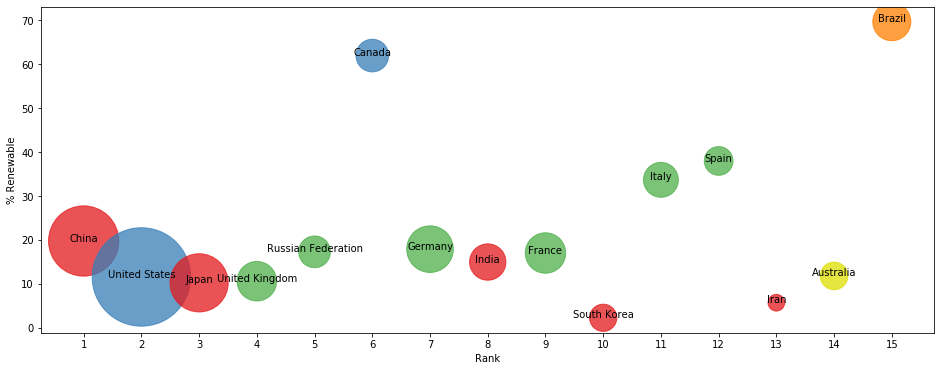

In [97]:
# plot_optional() # Be sure to comment out plot_optional() before submitting the assignment!

This is an example of a visualization that can be created to help understand the data. This is a bubble chart showing % Renewable vs. Rank. The size of the bubble corresponds to the countries' 2014 GDP, and the color corresponds to the continent.


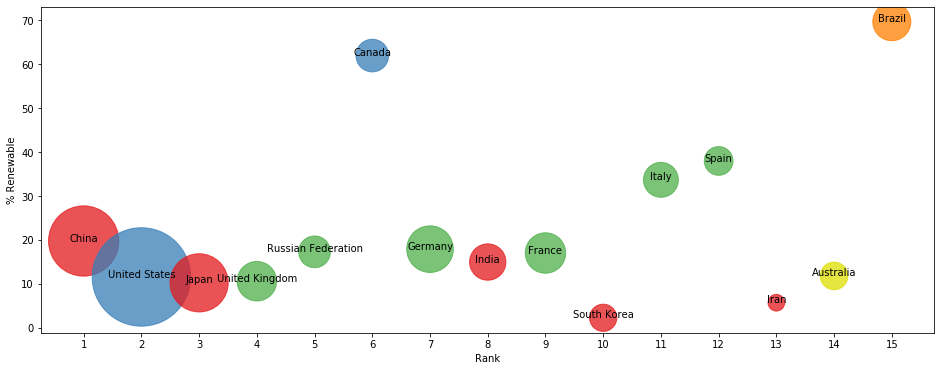

In [118]:
# globalcopy = globals().copy()
# res = {k:v() for k,v in  globalcopy.items() if (not k.startswith('_'))
# and (str(type(v)) in ["<class 'function'>",'function'])  and (v.__code__.co_argcount==0)}

In [100]:
# q1 = res['answer_one']
# print(type(q1))
# print(q1.shape)

<class 'pandas.core.frame.DataFrame'>
(15, 20)
